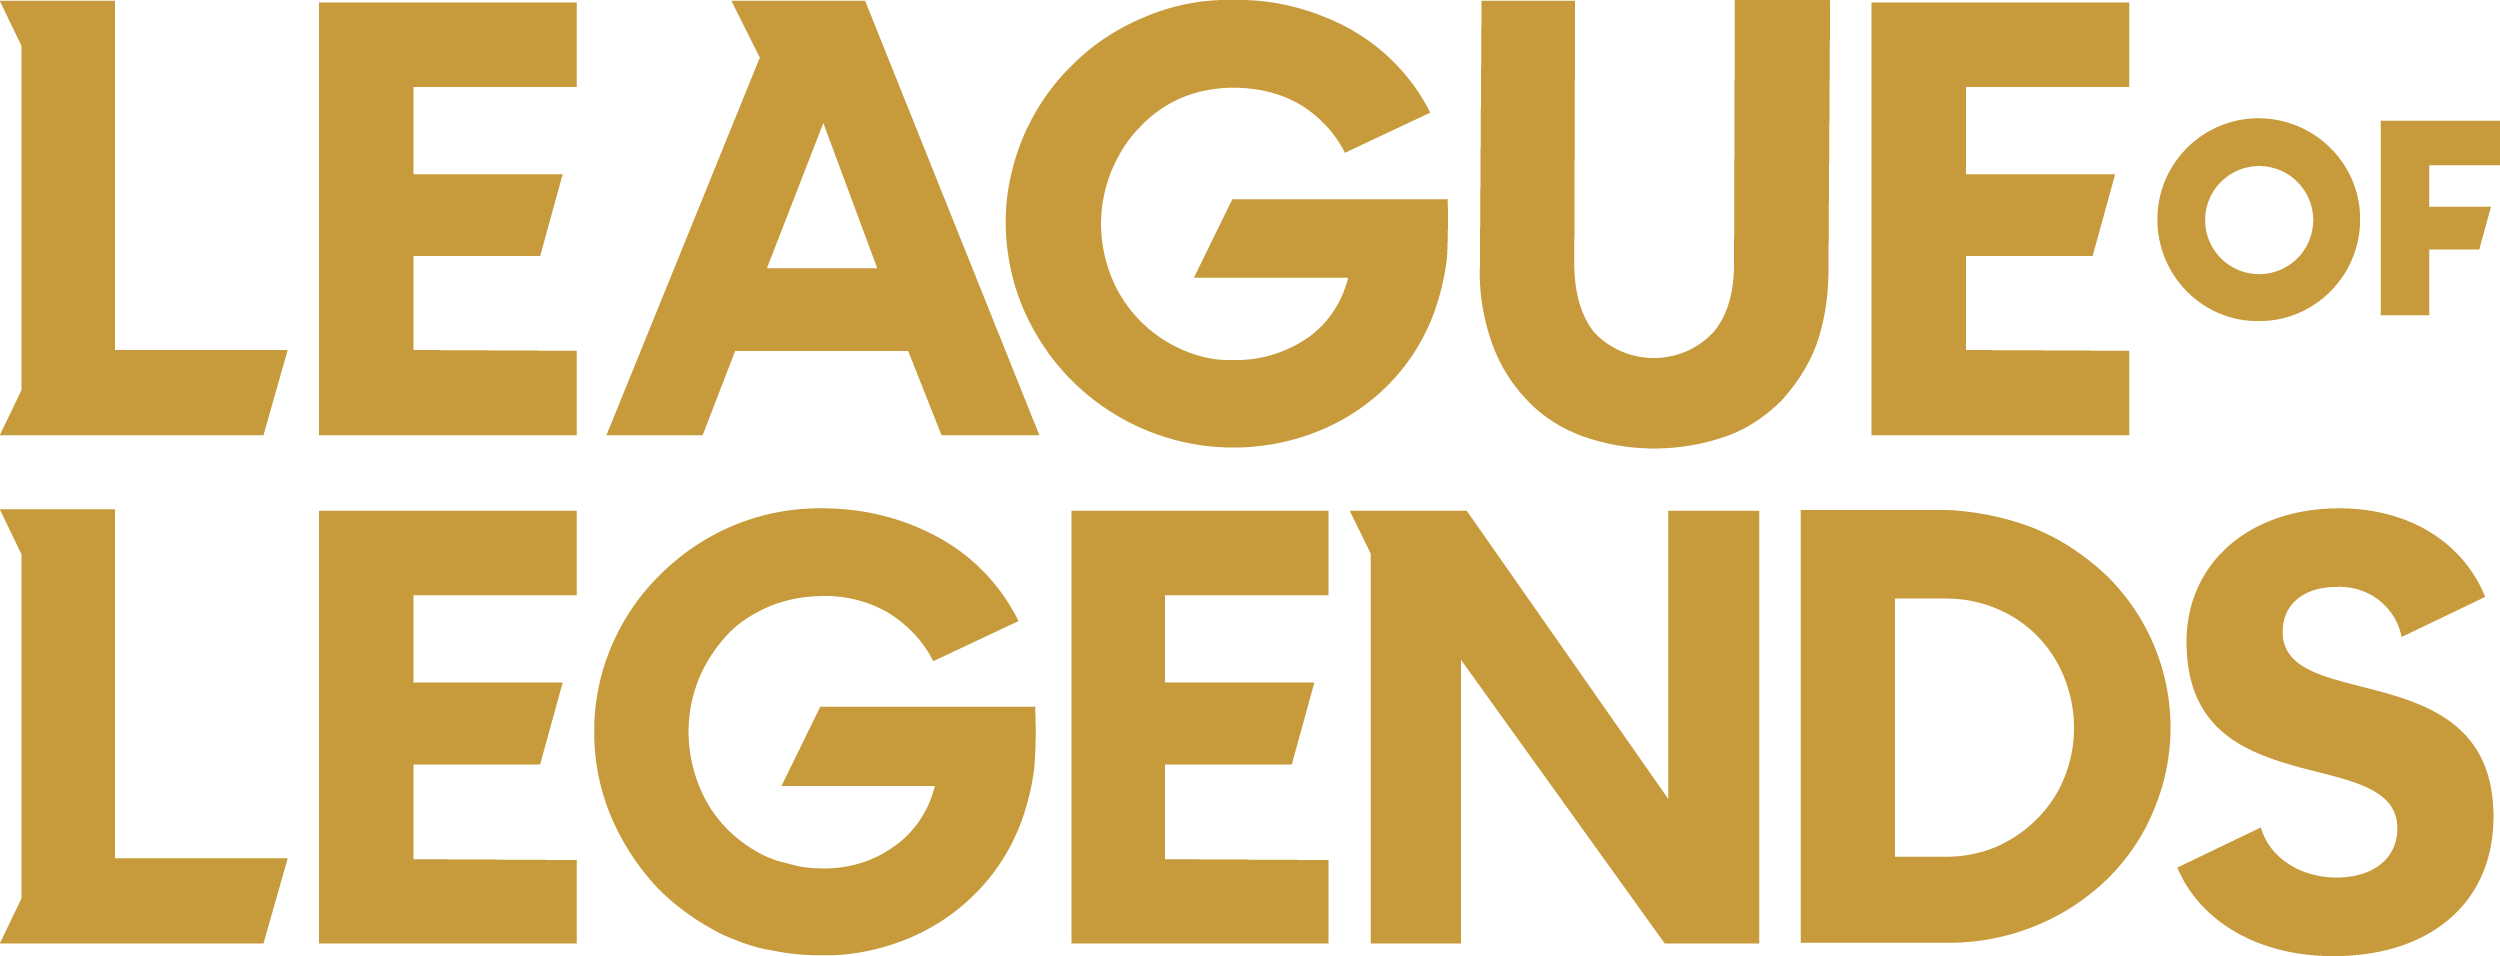

In [42]:
from IPython.display import Image
Image('data/League_of_Legends_2019_vector.png')

# Introduction
league of legends is a competitive MOBA game, where two teams
composed of 5 player's each have to win by destroying the enemy nexus "base".

in the game each player has to "kill minions/monsters/players" in order to get
gold with would result in a game advantage with would make it easier for the team to win.

# Data
This project uses 10-minutes of data collected from over twenty-six-thousand unique league of legends games.

the games were collected from high-elo player games, a.k.a. the top 0.01% players in the game.<br>
the data contains stats like gold per team,
kills, dragon kills, tower destroyed, minion killed and so on...
<br> and of course who won at the end.
- note : usually the games take on average 26+ minutes, with game's rarely ending before
the 15-minute mark, thus we can reasonably assume that anything can happen after the 10-minute mark.

# Purpose
the purpose of this project is to build a machine learning model that can predict as accurately
as possible which team would win the match. based on the stats at the end first 10 minutes of each match.

our assumption is that the biggest lead a.k.a. team with most kill's, gold, dragons etc...
would most likely win, and we will test that assumption.

### Import required Libraries

In [43]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

## data overview

In [44]:
league = pd.read_csv('data/league_f10min_data.csv')
pd.set_option('display.max_columns', None)
league.head()

,gameId,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueFirstTowerLane,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragnoType,blueDragon,blueRiftHeralds,redWins,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragnoType,redDragon,redRiftHeralds
0,4247263043,0,14870,2889,32,6.4,199,53,0,3,9,7,19,2,0,0,[],0,0,0,0,0,0,[],0,0,1,18397,3297,36,7.2,229,32,0,9,3,22,17,8,0,0,[],0,0,0,0,0,1,['WATER_DRAGON'],1,0
1,4247155821,1,14497,2617,33,6.6,229,44,0,2,3,2,17,1,0,0,[],0,0,0,0,0,0,[],0,1,0,15893,4778,36,7.2,234,57,0,3,2,2,15,5,0,0,[],0,0,0,0,0,0,[],0,0
2,4243963257,0,15617,1757,34,6.8,223,39,0,3,11,4,15,6,0,0,[],0,0,0,0,0,0,[],0,0,1,20409,4324,37,7.4,236,45,0,11,3,11,21,4,1,0,['BOT_LANE'],1,0,0,1,0,1,['FIRE_DRAGON'],1,1
3,4241678498,0,15684,1439,35,7.0,251,64,0,3,4,2,62,4,0,0,[],0,0,0,0,0,0,[],0,0,1,16150,3633,35,7.0,256,48,0,4,3,5,12,7,0,0,[],0,0,0,0,0,0,[],0,0
4,4241538868,1,17472,3512,35,7.0,257,46,0,7,5,6,17,6,0,0,[],0,0,0,0,0,0,[],0,1,0,15588,3323,34,6.8,194,56,0,5,7,7,20,3,0,0,[],0,0,0,0,0,0,[],0,0


#### we can see a summary of the data by using info.

In [45]:
league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26409 entries, 0 to 26408
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   gameId                      26409 non-null  int64  
 1   blueWins                    26409 non-null  int64  
 2   blueTotalGolds              26409 non-null  int64  
 3   blueCurrentGolds            26409 non-null  int64  
 4   blueTotalLevel              26409 non-null  int64  
 5   blueAvgLevel                26409 non-null  float64
 6   blueTotalMinionKills        26409 non-null  int64  
 7   blueTotalJungleMinionKills  26409 non-null  int64  
 8   blueFirstBlood              26409 non-null  int64  
 9   blueKill                    26409 non-null  int64  
 10  blueDeath                   26409 non-null  int64  
 11  blueAssist                  26409 non-null  int64  
 12  blueWardPlaced              26409 non-null  int64  
 13  blueWardKills               264

#### it seems there is no null values but let's run the following line to be sure.

In [46]:
league.isna().values.any()

False

# cleanup

#### next lets remove any duplicate game's so first lets see if there are any duplicates

In [47]:
number_of_unique = len(league["gameId"].unique())
number_of_entries = league.shape[0]
print("number of entries:", number_of_entries, "number of unique entries:", number_of_unique)

number of entries: 26409 number of unique entries: 26354


#### we can see that there is some duplicate games, so lets remove those duplicates

In [48]:
league = league.drop_duplicates('gameId', keep='first').reindex()
print("number of entries:", league.shape[0], "number of unique entries:", len(league["gameId"].unique()))

number of entries: 26354 number of unique entries: 26354


#### Removing columns we dont need
- gameId clearly that column doesn't affect the game outcome.
- redWins if blue didn't win that means red won, hence we can remove that too.
<br>we will rename blueWins to winner.
- remove DragnoType and FirstTowerLane as they are not numbers and cause problems for now.
the data from those columns also present in other columns expect we do not know the specific type
with i assume would not affect the outcome much.

In [49]:
league_data = league.drop(["gameId", "redWins"], axis=1).rename(columns={"blueWins": "Winner"})
league_data = league_data.drop(["redDragnoType", "blueDragnoType", "blueFirstTowerLane", "redFirstTowerLane"], axis=1)
league_data

,Winner,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragon,blueRiftHeralds,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragon,redRiftHeralds
0,0,14870,2889,32,6.4,199,53,0,3,9,7,19,2,0,0,0,0,0,0,0,0,0,0,18397,3297,36,7.2,229,32,0,9,3,22,17,8,0,0,0,0,0,0,0,1,1,0
1,1,14497,2617,33,6.6,229,44,0,2,3,2,17,1,0,0,0,0,0,0,0,0,0,1,15893,4778,36,7.2,234,57,0,3,2,2,15,5,0,0,0,0,0,0,0,0,0,0
2,0,15617,1757,34,6.8,223,39,0,3,11,4,15,6,0,0,0,0,0,0,0,0,0,0,20409,4324,37,7.4,236,45,0,11,3,11,21,4,1,0,1,0,0,1,0,1,1,1
3,0,15684,1439,35,7.0,251,64,0,3,4,2,62,4,0,0,0,0,0,0,0,0,0,0,16150,3633,35,7.0,256,48,0,4,3,5,12,7,0,0,0,0,0,0,0,0,0,0
4,1,17472,3512,35,7.0,257,46,0,7,5,6,17,6,0,0,0,0,0,0,0,0,0,1,15588,3323,34,6.8,194,56,0,5,7,7,20,3,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26404,0,16762,5072,36,7.2,206,52,0,7,5,9,21,4,0,0,0,0,0,0,0,0,0,0,14779,3709,36,7.2,205,67,0,5,7,1,18,4,0,0,0,0,0,0,0,1,1,1
26405,0,35765,1440,39,7.8,191,16,0,18,27,17,23,0,1,0,2,0,2,0,0,1,1,0,42001,9568,44,8.8,279,73,0,27,18,20,22,0,0,0,3,1,0,2,0,0,0,0
26406,0,15712,4137,34,6.8,218,55,0,3,0,4,17,8,0,0,0,0,0,0,0,0,0,0,14845,1345,34,6.8,239,60,0,0,3,0,43,3,0,0,0,0,0,0,0,0,0,0
26407,1,15850,3220,33,6.6,193,48,0,6,4,14,17,6,0,0,0,0,0,0,0,1,1,0,14773,3673,33,6.6,204,52,0,4,6,8,16,4,0,0,0,0,0,0,0,0,0,0


### First try
- #### first lets see what is the percentage of blue wins.

In [50]:
blue_percent = league_data.loc[league_data["Winner"] == 1].shape[0]
print("blue won at", blue_percent/league_data.shape[0] ," of the matches")

blue won at 0.5010245124079836  of the matches


#### hence, out dummy classifier would accurately predict about 50.011% of the games if we just always say blue wins.
- #### let's try to use the data as is, and see what is the initial accuracy.

In [51]:
train_set, test_set = train_test_split(league_data, test_size = 0.2, random_state = 2)
# print( train_set.shape)
# print( test_set.shape)

def split_test_train(data_set):
    return data_set.drop('Winner', axis = 1), data_set['Winner']

x_train, y_train = split_test_train(train_set)
x_test, y_test = split_test_train(test_set)

In [52]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)

reg = LogisticRegression(max_iter = 1000)
x_train_copy = scaler.transform(x_train) # I want to avoid changing the original
scores = cross_val_score(reg, x_train_copy, y_train, scoring = 'accuracy', cv = 10)

print(scores.mean())

0.7396951080712192


#### we get about 73.96% accuracy, which is not bad at all considering we only changed the data a little bit.

### next step lets create some transformation to the data in hopes of improving the accuracy even more.
- first lets see the correlation between features and winning.
- secondly lets remove all the columns that have only one unique value, if there is any.

#### at any case we will use transformation only on the train set

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

def remove_non_unique(data_set : pd.DataFrame, log : False):
    drop = ["blueDeath" , "redDeath"]
    for column in data_set.columns:
        if len(data_set[column].unique()) == 1:
            drop.append(column)
    if log:
        print("dropped",drop)
    return data_set.drop(drop, axis=1)

class CleanData(BaseEstimator, TransformerMixin):
    def __init__(self, log = False):
        self.log = log
    def fit(self, X):
        return self
    def transform(self, X):
        if self.log:
            print("running Cleaner...")
        return remove_non_unique(X, self.log)

cleanClass = CleanData(log=True)
train_set_copy = cleanClass.transform(train_set)

running Cleaner...
dropped ['blueDeath', 'redDeath', 'blueFirstBlood', 'redFirstBlood']


##### we have to many columns so lets try to cut out some features.

- we will discard columns that are highly correlated for instance redDeath == blueKills and so on
<br> for that we will discard columns with over 0.95 correlation,( of course excluding the win )

In [54]:
def remove_correlated(data_set : pd.DataFrame, percent : float, ignore : [], log = False):
    corr_m = data_set.corr()
    drop = []
    for look in data_set.columns:
        if look in ignore or look in drop:
            continue
        for at in data_set.columns:
            if look == at or at in ignore or at in drop:
                continue
            if abs(corr_m[look][at]) > percent:
                if log:
                    print(look, at, abs(corr_m[look][at]))
                drop.append(at)
    if log:
        print("dropped highly correlated:", drop)
    return data_set.drop(drop, axis=1)

class FixCorrelation(BaseEstimator, TransformerMixin):
    def __init__(self, percent : float, ignore : [], log = False):
        self.percent = percent
        self.ignore = ignore
        self.log = log
    def fit(self, X):
        return self
    def transform(self, X):
        if self.log:
            print("running fix_correlation...")
        return remove_correlated(X, self.percent, self.ignore, self.log)

ignore_list = ["Winner", "blueTotalGolds", "redTotalGolds", "blueKill", "redKill"]
cor_fixer = FixCorrelation(0.9, ignore_list, True)

league_data_modified2 = cor_fixer.transform(train_set_copy)
corr = league_data_modified2.corr()
corr["Winner"]

running fix_correlation...
blueTotalLevel blueAvgLevel 1.000000000000001
blueFirstInhibitor blueInhibitor 0.9962378917457883
blueFirstDragon blueDragon 0.9932062119553003
redTotalLevel redAvgLevel 1.0000000000000042
redFirstInhibitor redInhibitor 0.9970306482058868
redFirstDragon redDragon 0.9947171455665598
dropped highly correlated: ['blueAvgLevel', 'blueInhibitor', 'blueDragon', 'redAvgLevel', 'redInhibitor', 'redDragon']


Winner                        1.000000
blueTotalGolds                0.140581
blueCurrentGolds              0.155144
blueTotalLevel                0.127596
blueTotalMinionKills          0.135577
blueTotalJungleMinionKills    0.070803
blueKill                      0.212249
blueAssist                    0.136463
blueWardPlaced                0.019061
blueWardKills                 0.052219
blueFirstTower                0.123892
blueFirstInhibitor            0.061512
blueTowerKills                0.111162
blueMidTowerKills             0.086144
blueTopTowerKills             0.058318
blueBotTowerKills             0.078196
blueFirstDragon               0.202659
blueRiftHeralds               0.102564
redTotalGolds                -0.125944
redCurrentGolds              -0.159080
redTotalLevel                -0.100539
redTotalMinionKills          -0.158807
redTotalJungleMinionKills    -0.096007
redKill                      -0.194525
redAssist                    -0.113224
redWardPlaced            

### combining the data
- a lot of rows are just opposite, so we can in fact combine them,
for instance we can create GoldDiff = redGold - blueGold etc...
- for the last step we will drop any columns with correlation higher than 80%.

so lets do exactly that.

In [55]:
def combine_data(data_set : pd.DataFrame, pre1 : str, pre2 : str, ignore):
    data_new = data_set.copy()
    drop = []
    for column in data_set.columns:
        if column.startswith(pre2) or not column.startswith(pre1):
            continue
        if column in ignore:
            continue
        label = column[len(pre1):]
        column_other = pre2 + label
        if column_other not in data_set.columns:
            continue
        data_new[column] -= data_new[column_other]
        data_new = data_new.rename(columns={column: label + "_diff"})
        drop.append(column_other)
    return data_new.drop(drop, axis=1)

class ColumnMerger(BaseEstimator, TransformerMixin):
    def __init__(self, pre1 : str, pre2 : str, ignore):
        self.pre1 = pre1
        self.pre2 = pre2
        self.ignore = ignore
    def fit(self, X):
        return self
    def transform(self, X):
        return combine_data(X, self.pre1, self.pre2, self.ignore)

columnMerger = ColumnMerger("blue", "red", ["Winner"])
cor_fixer2 = FixCorrelation(0.8, ["Winner"], True)

league_data_modified3 = columnMerger.transform(league_data_modified2)
league_data_modified3 = cor_fixer2.transform(league_data_modified3)
league_data_modified3

running fix_correlation...
TotalGolds_diff TotalLevel_diff 0.8525865108439069
TotalGolds_diff Kill_diff 0.8988614786637473
dropped highly correlated: ['TotalLevel_diff', 'Kill_diff']


,Winner,TotalGolds_diff,CurrentGolds_diff,TotalMinionKills_diff,TotalJungleMinionKills_diff,Assist_diff,WardPlaced_diff,WardKills_diff,FirstTower_diff,FirstInhibitor_diff,TowerKills_diff,MidTowerKills_diff,TopTowerKills_diff,BotTowerKills_diff,FirstDragon_diff,RiftHeralds_diff
17036,0,-1556,-841,2,3,-9,-6,2,0,0,0,0,0,0,-1,1
21465,1,-104,-1509,-32,-8,3,-5,2,0,0,0,0,0,0,1,0
20481,0,-7184,-8542,-65,-48,-27,-4,0,-1,0,-2,-1,-1,0,-1,0
4797,0,-1752,-1922,-7,12,-6,-7,2,0,0,0,0,0,0,0,0
18012,0,-2065,-1745,38,-21,-6,2,0,0,0,0,0,0,0,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18906,1,2461,-1409,6,0,3,-52,-2,1,0,1,0,1,0,1,0
11798,0,-1182,-667,-18,9,-8,-11,-1,0,0,0,0,0,0,-1,0
6637,0,-3391,214,-30,0,-12,5,-2,0,0,0,0,0,0,-1,0
2575,1,1634,1136,-29,-3,9,27,-1,0,0,0,0,0,0,1,0


- we lost TotalLevel_diff, and Kill_diff, due to high correlation with totalGold,
<br> usually the team with more kills is higher in level overall and would have more gold,
so we can conclude that kill's play a big role in setting that gold diff.

## quick test

In [56]:
x_train, y_train = split_test_train(league_data_modified3)

scaler = preprocessing.StandardScaler().fit(x_train)

reg = LogisticRegression()
x_train_copy = scaler.transform(x_train) # I want to avoid changing the original
scores = cross_val_score(reg, x_train_copy, y_train, scoring = 'accuracy', cv = 10)

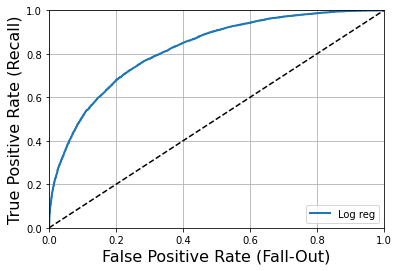

cross val score: 0.7420194512898997


In [57]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)


y_probas = cross_val_predict(reg, x_train_copy, y_train, cv=3, method="predict_proba")

y_scores = y_probas[:, 1] # score = proba of positive class
fpr_reg, tpr_reg, thresholds_reg = roc_curve(y_train,y_scores)

plot_roc_curve(fpr_reg, tpr_reg, "Log reg")
plt.legend(loc="lower right")
plt.show()

print("cross val score:", scores.mean())

### Improvement!
our data manipulation was not in vane, we see a score about 3% better.

we can also see that we have a decent curve,
we again look at the first 10 minutes of a match, so an accuracy of 74% from the first 10 minutes
is quite impressive in fact that just shows that the 10 minutes of the game, define almost 75% of games.

## creating a pipeline
as we created a lot of transformation lets, combine them for our convenience.

#### and lets look at the data.

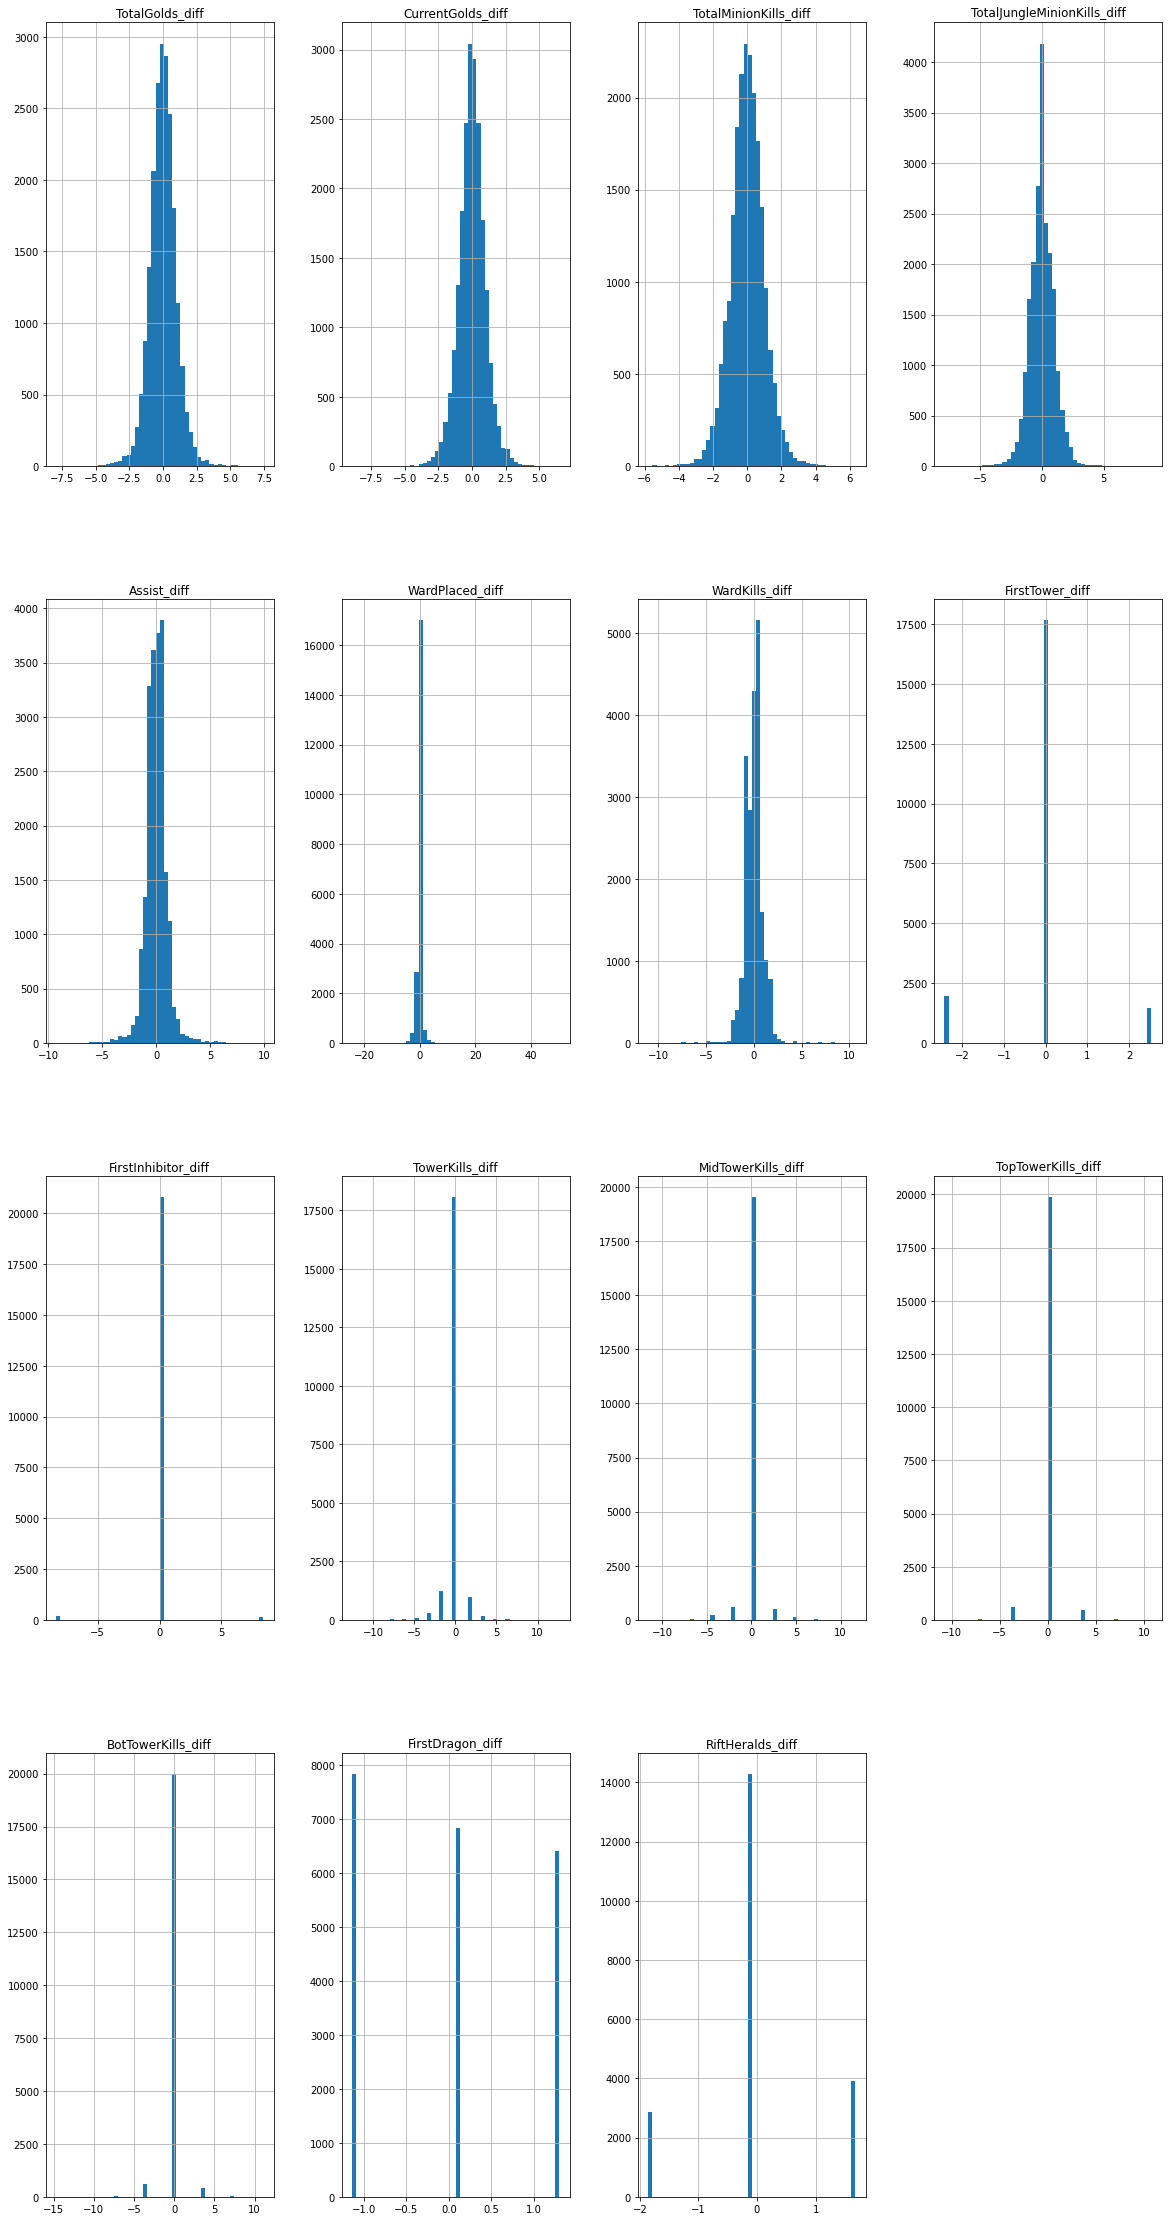

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class ScaleData(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    def transform(self,X):
        tmp = X.copy()
        X = StandardScaler().fit_transform(X)
        return pd.DataFrame(X, index = tmp.index, columns = tmp.columns)

ignore_list = ["Winner", "blueTotalGolds", "redTotalGolds", "blueKill", "redKill"]
model_pipeline = Pipeline([
        ('cleaner',  CleanData()),
        ('corr1', FixCorrelation(0.9, ignore_list)),
        ('merger', ColumnMerger("blue", "red", ["Winner"])),
        ('corr2', FixCorrelation(0.8, ["Winner"])),
        ('scaler', ScaleData()),
    ])

train_set, test_set = train_test_split(league_data, test_size = 0.2, random_state = 2)
def split_test_train(data_set):
    return data_set.drop('Winner', axis = 1), data_set['Winner']

x_train, y_train = split_test_train(train_set)

x_train_copy = model_pipeline.fit_transform(x_train)
x_train_copy.hist(bins = 50, figsize = (20,40))
plt.show()
#
# model_pipeline.fit(x_train)
# x_train_copy = model_pipeline.transform(x_train)
# x_train_copy
#
# reg = LogisticRegression(max_iter = 1000)
# scores = cross_val_score(reg, x_train_copy, y_train, scoring = 'accuracy', cv = 10)
#
# print("cross val score:",scores.mean())


### skewness
the data is a little bit skewed, but it doesn't seem like a big issue, in fact league of legends,
does not have high values so we will leave the data as is.


In [59]:
# league_data_modified3.hist(bins = 50, figsize = (20,40))
# plt.show()
#
# # from pandas.plotting import scatter_matrix
# # attributes = ["Winner", "TotalGolds_diff", "TotalMinionKills_diff", "Assist_diff", "FirstDragon_diff"]
# # scatter_matrix(league_data_modified3[attributes], figsize=(20, 20))


### Correlations
let's take a look at the correlations with the new data.


In [60]:
train_set_copy = model_pipeline.fit_transform(train_set)
train_set_copy.corr()["Winner"]


Winner                         1.000000
TotalGolds_diff                0.515035
CurrentGolds_diff              0.229926
TotalMinionKills_diff          0.339289
TotalJungleMinionKills_diff    0.183464
Assist_diff                    0.368340
WardPlaced_diff                0.042821
WardKills_diff                 0.094969
FirstTower_diff                0.159206
FirstInhibitor_diff            0.085646
TowerKills_diff                0.172241
MidTowerKills_diff             0.123129
TopTowerKills_diff             0.087000
BotTowerKills_diff             0.119190
FirstDragon_diff               0.235921
RiftHeralds_diff               0.133741
Name: Winner, dtype: float64

# observations
we can see from the correlation matrix some interesting insight,
for instance gold by far has the biggest impact on games,
but that actually was to be expected.
<br> what's more surprising is the fact that "assists" impact the game a lot,
that can be explained by the fact that team's that play better together,
would have more assist's and would perform better overall.
hence, teamwork is a key to success.

another observation, first dragon has a huge impact on games,
while rift herald having a twice as less impact.

we can clearly see that vision  overall has impact on game ( wards ),
but at least at the 10-min mark, clearing wards is more important than placing them,
that might be explained by the fact that usually everyone uses wards,
but not everyone clears them, thus making it easier for gank's to occur.

we can also see that Mid and Bot has higher impact on games,
hence kills at mid/bot out perform top by at least 30%,
that also might be explained by the fact that bot/mid are close to th drake,
while the top lane being far away.

## Model building
now lets test some other option!
<br> we will test randomForest KNN and DecisionTree

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

x_train_copy = model_pipeline.transform(x_train)

def train_models(_models, X, y):
    _scores = {}
    for model in _models:
        score = cross_val_score(model, X, y, scoring = 'accuracy', cv = 10)
        _scores[model] = score.mean()
    return _scores

models = [
    LogisticRegression(random_state=40),
    RandomForestClassifier(random_state=41),
    DecisionTreeClassifier(random_state=42),
    KNeighborsClassifier(n_neighbors=10),
    KNeighborsClassifier(n_neighbors=25),
    KNeighborsClassifier(n_neighbors=50),
]

scores = train_models(models, x_train_copy, y_train)
for model in scores:
    print(model, scores[model])

LogisticRegression(random_state=40) 0.7420194512898997
RandomForestClassifier(random_state=41) 0.7349053437738148
DecisionTreeClassifier(random_state=42) 0.6510456676590701
KNeighborsClassifier(n_neighbors=10) 0.7082493434211201
KNeighborsClassifier(n_neighbors=25) 0.720912858329217
KNeighborsClassifier(n_neighbors=50) 0.7277899091541358


## Conclusion
the best model is LogisticRegression,
but we can try more setting for KNN because with 50 neighbors we improved the score


In [62]:
models = []
for i in range(80, 120, 5):
    models.append(KNeighborsClassifier(n_neighbors=i))

scores = train_models(models, x_train_copy, y_train)
for model in scores:
    print(model, scores[model])

KNeighborsClassifier(n_neighbors=80) 0.7322487298044075
KNeighborsClassifier(n_neighbors=85) 0.7322484598850323
KNeighborsClassifier(n_neighbors=90) 0.7321534482650033
KNeighborsClassifier(n_neighbors=95) 0.7311574907575107
KNeighborsClassifier(n_neighbors=100) 0.7311100074407774
KNeighborsClassifier(n_neighbors=105) 0.7310151082871545
KNeighborsClassifier(n_neighbors=110) 0.7310153782065296
KNeighborsClassifier(n_neighbors=115) 0.7310151532737171


### KNN conclusion
knn peaks at about 73% so log reg is the winner here.



In [63]:
models = []
for i in range(5, 40, 5):
    models.append(RandomForestClassifier(n_estimators=i, n_jobs=-1, max_depth=4))
    models.append(RandomForestClassifier(n_estimators=i, n_jobs=-1, max_depth=8))
    models.append(RandomForestClassifier(n_estimators=i, n_jobs=-1, max_depth=10))

scores = train_models(models, x_train_copy, y_train)
for model in scores:
    print(model, scores[model])

RandomForestClassifier(max_depth=4, n_estimators=5, n_jobs=-1) 0.7297817117027143
RandomForestClassifier(max_depth=8, n_estimators=5, n_jobs=-1) 0.7330079230333899
RandomForestClassifier(max_depth=10, n_estimators=5, n_jobs=-1) 0.732296325587547
RandomForestClassifier(max_depth=4, n_estimators=10, n_jobs=-1) 0.7334817664963474
RandomForestClassifier(max_depth=8, n_estimators=10, n_jobs=-1) 0.7383198463618917
RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1) 0.7361852789571754
RandomForestClassifier(max_depth=4, n_estimators=15, n_jobs=-1) 0.7367077528942105
RandomForestClassifier(max_depth=8, n_estimators=15, n_jobs=-1) 0.7388892862701911
RandomForestClassifier(max_depth=10, n_estimators=15, n_jobs=-1) 0.7387942071703183
RandomForestClassifier(max_depth=4, n_estimators=20, n_jobs=-1) 0.7356165588338764
RandomForestClassifier(max_depth=8, n_estimators=20, n_jobs=-1) 0.7416405744604087
RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1) 0.7391736013452783
Rand

### Random forest conclusion
random forest is still doing worse then the Log-Regression,
so we will choose log-regression as our model.

## Optimizing Best Model
LogisticRegression is the best model without any hyperparameter tuning.
 Now we will use RandomizedGridSearch to find the optimal parameters.

In [64]:
from scipy.stats import uniform, truncnorm

param_distributions = [{
    'C': uniform(0.01,2),
    'max_iter': [1000],
    'n_jobs' : [-1],
    # 'penalty': ['l1','l2'],
}]

LR = LogisticRegression(random_state = 1)
grid_LR = RandomizedSearchCV(LR, param_distributions, cv = 10, scoring = 'accuracy', n_iter = 20)
model = grid_LR.fit(x_train_copy, y_train)
print(model.best_score_)
print(model.best_params_)

0.7420668896200706
{'C': 1.3450742378238103, 'max_iter': 1000, 'n_jobs': -1}


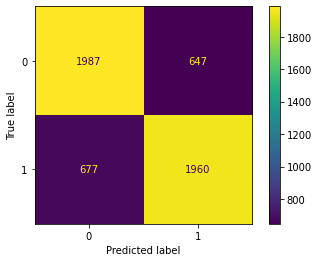

In [65]:
X = model_pipeline.fit_transform(x_test)
plot_confusion_matrix(model, X, y_test)
plt.show()

In [66]:
pred = model.predict(X)
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = pred).ravel()

acc = (tn + tp)/(tn + fp + fn + tp)

print('Accuracy: {:.2f}%'.format(acc*100))

Accuracy: 74.88%


## Analyzing Predictions
#### now i would like to take a look at the predicted data


In [120]:
pipe_no_scalar = Pipeline([
        ('cleaner',  CleanData()),
        ('corr1', FixCorrelation(0.9, ignore_list)),
        ('merger', ColumnMerger("blue", "red", ["Winner"])),
        ('corr2', FixCorrelation(0.8, ["Winner"])),
    ])


pipe_no_scalar.fit_transform(x_train)
X = pipe_no_scalar.transform(x_test)

blueWins = X.loc[pred == 1]
blueLoses = X.loc[pred == 0]
actualWins = X.loc[y_test == 1]
actualLoses = X.loc[y_test == 0]

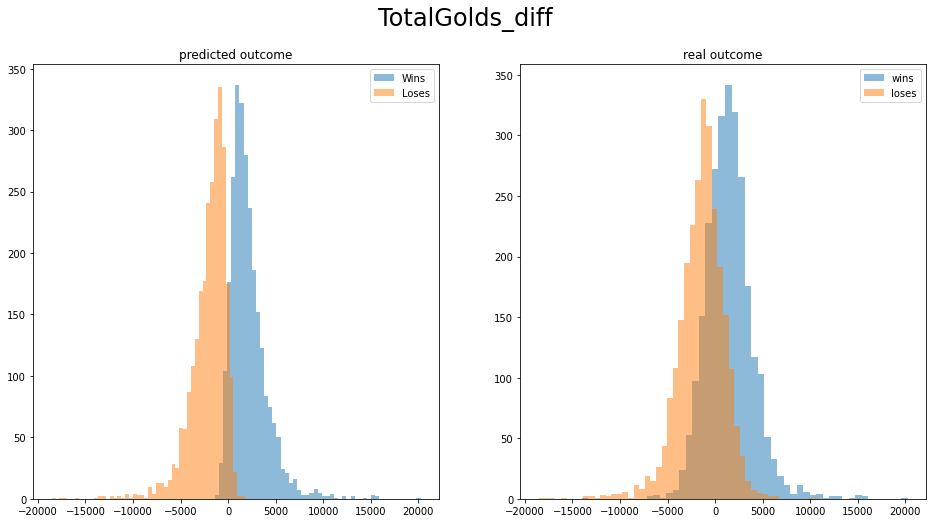

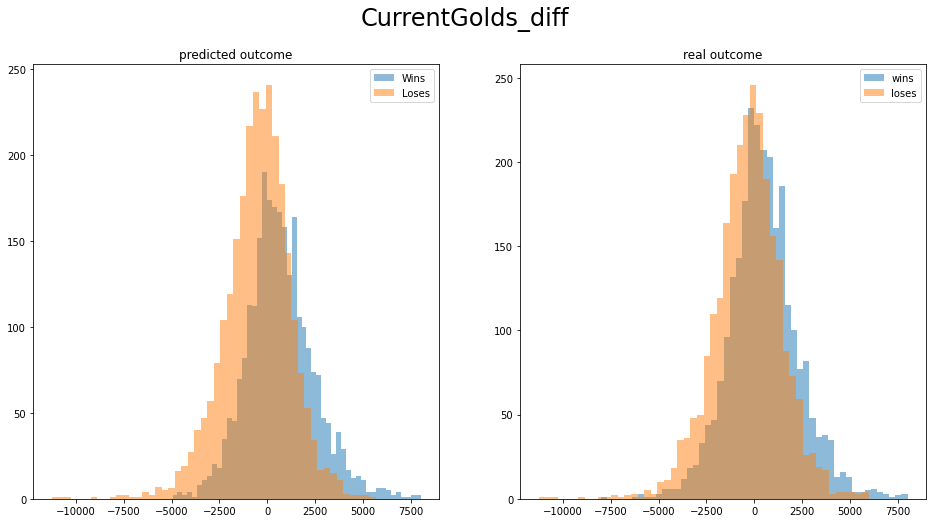

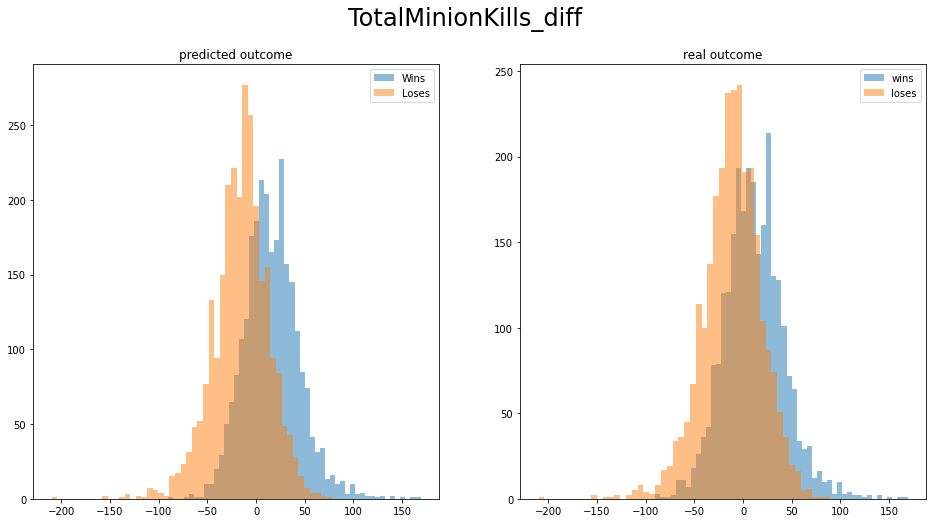

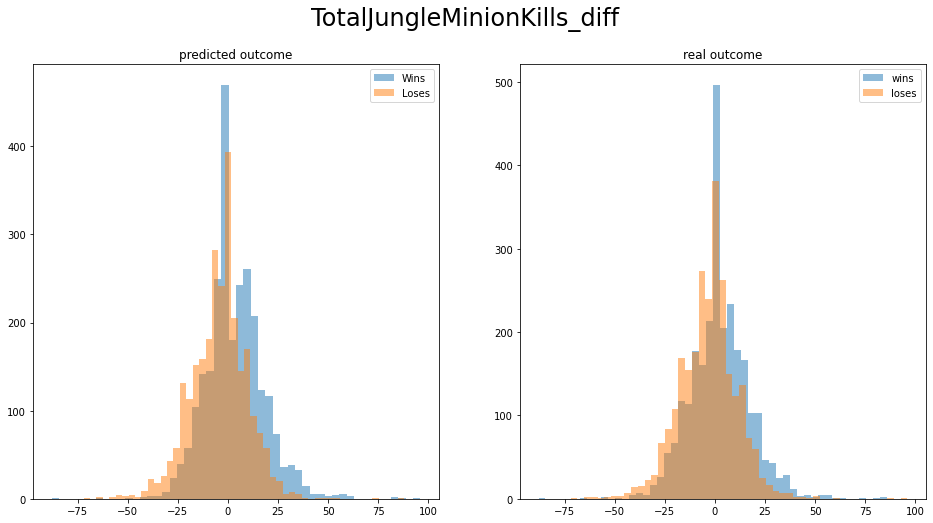

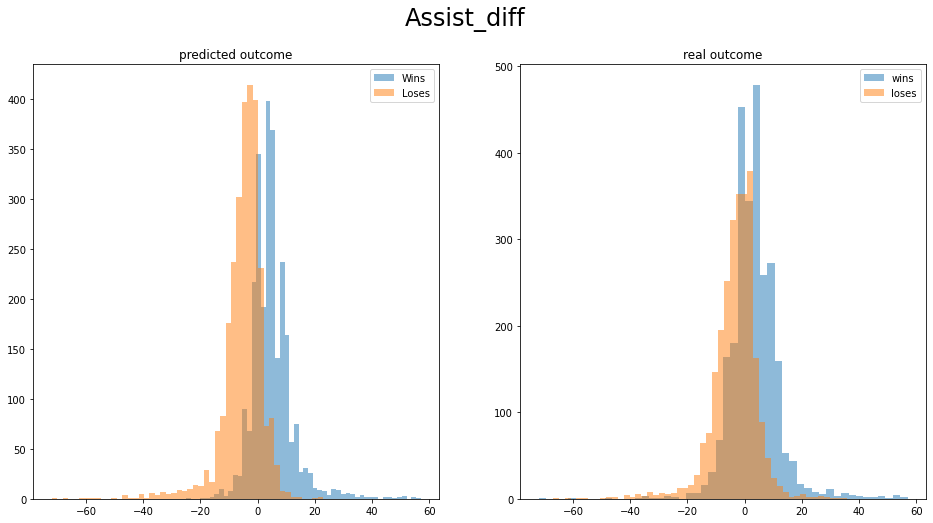

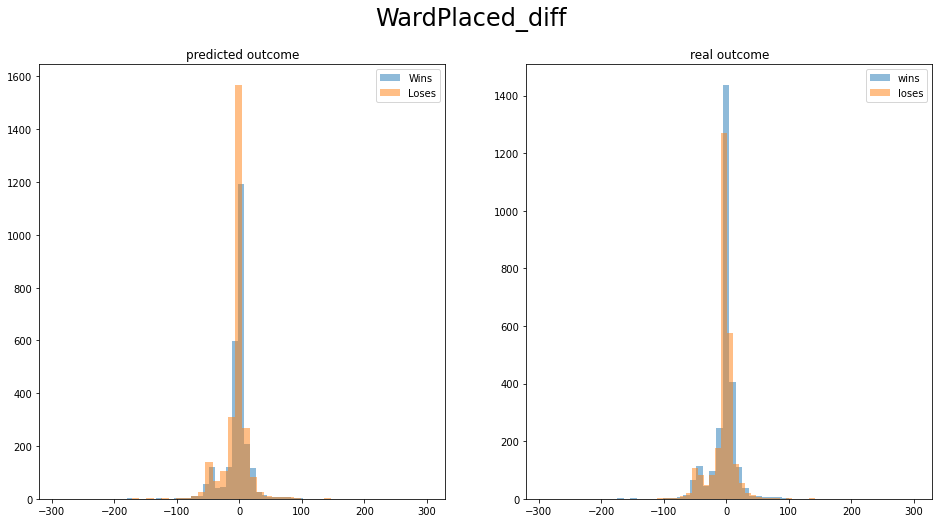

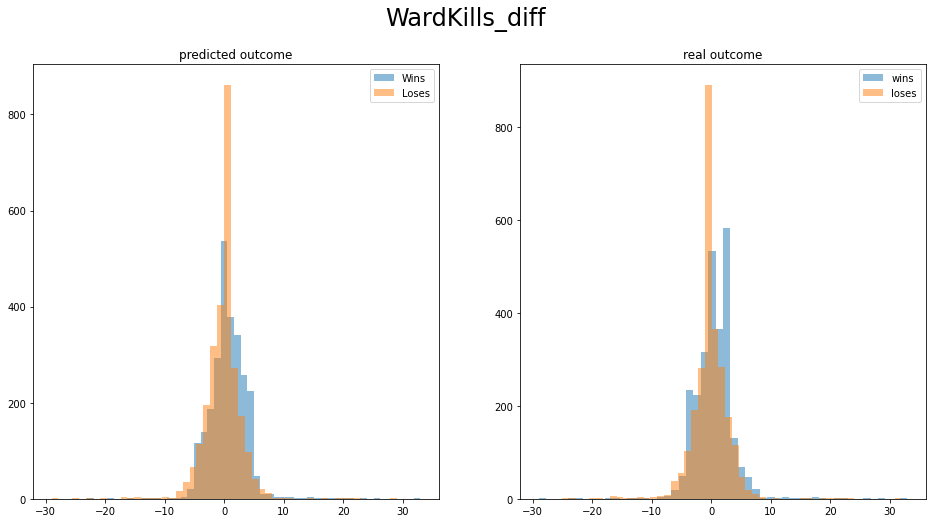

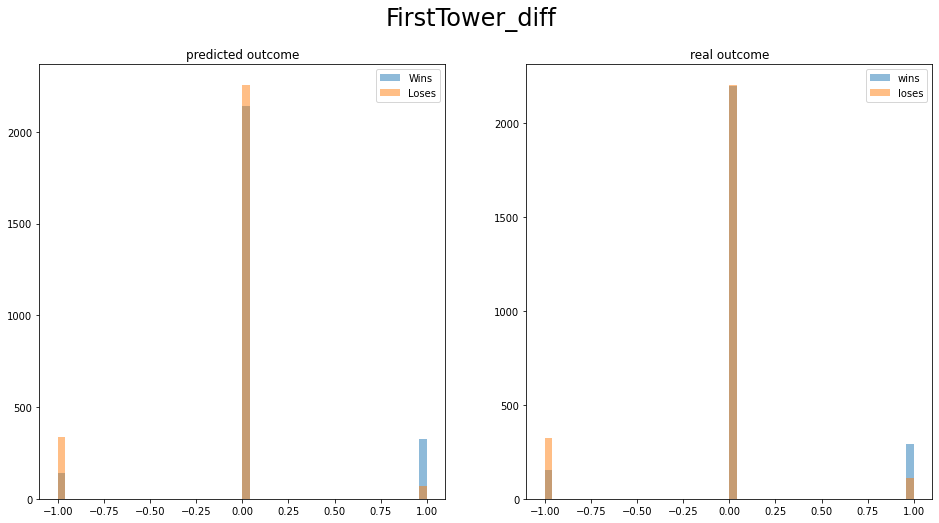

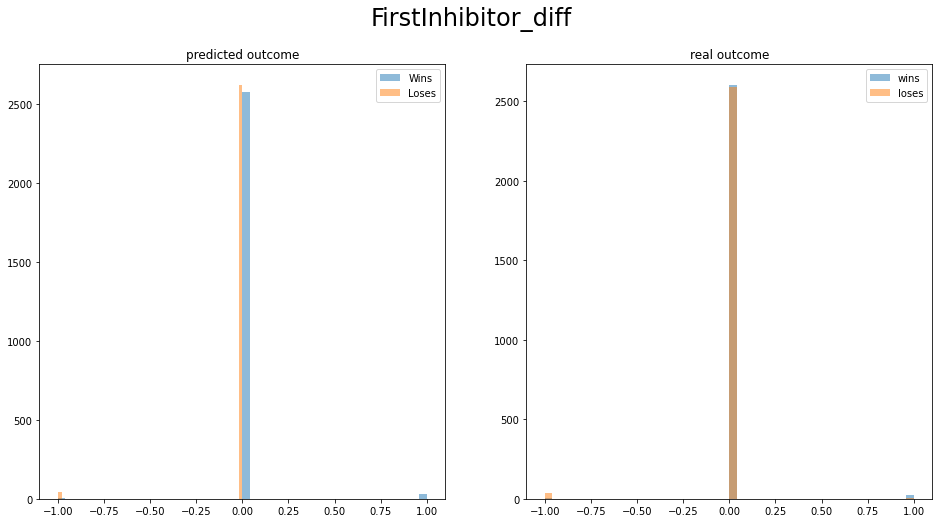

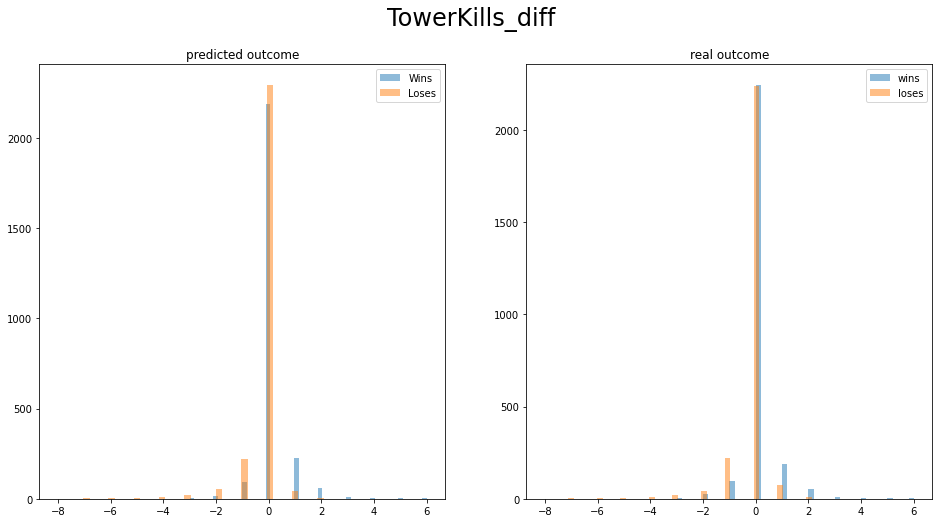

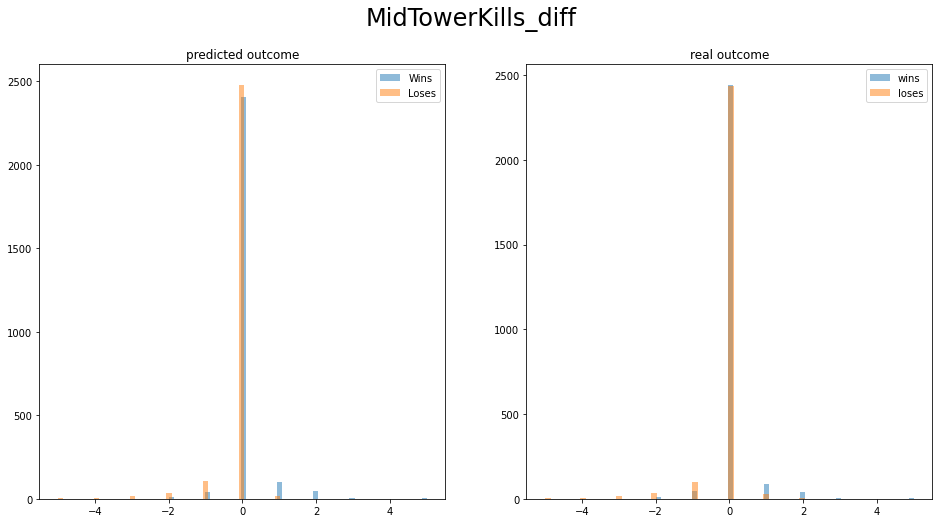

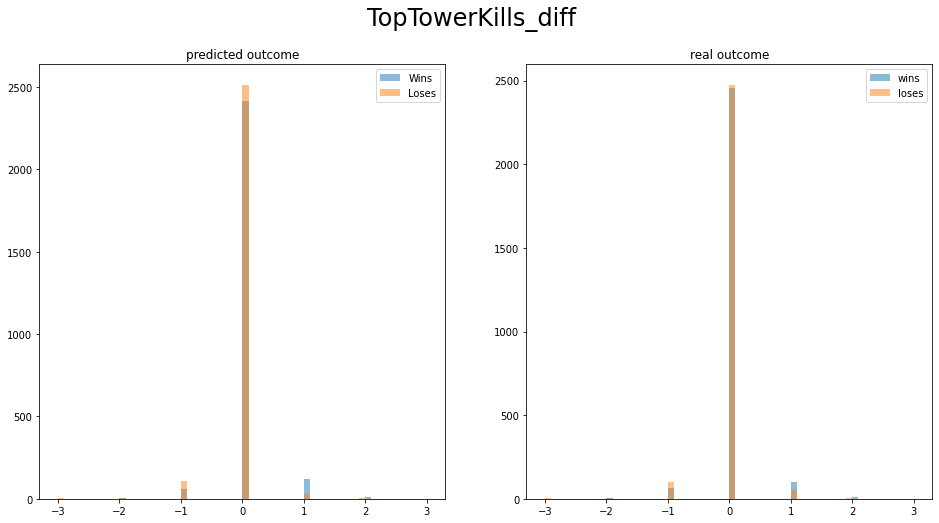

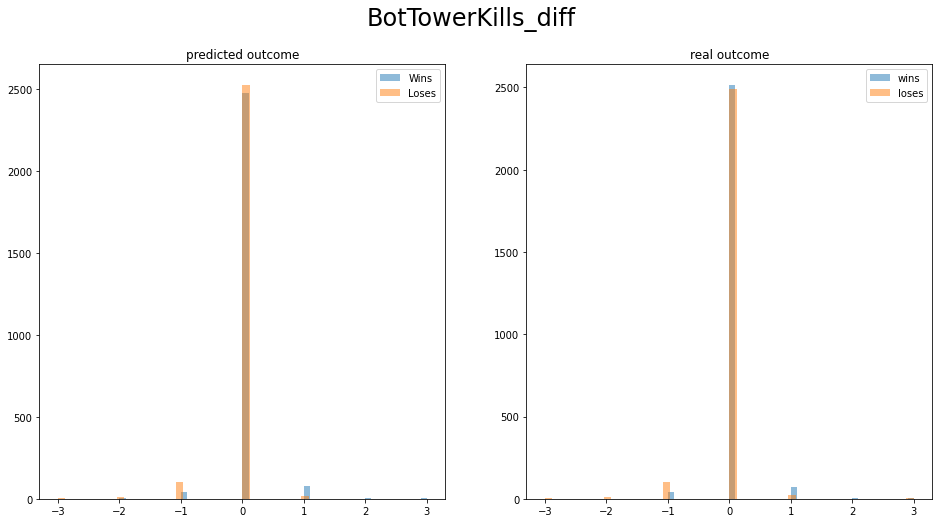

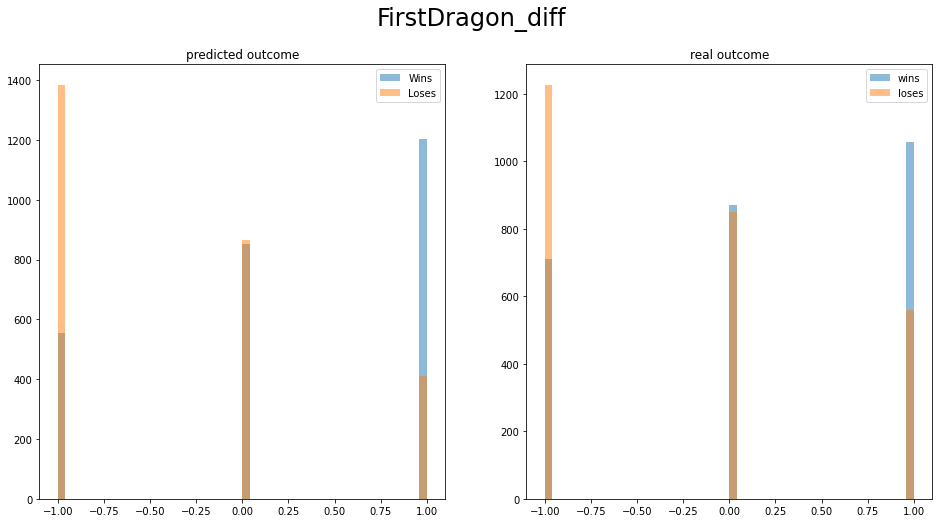

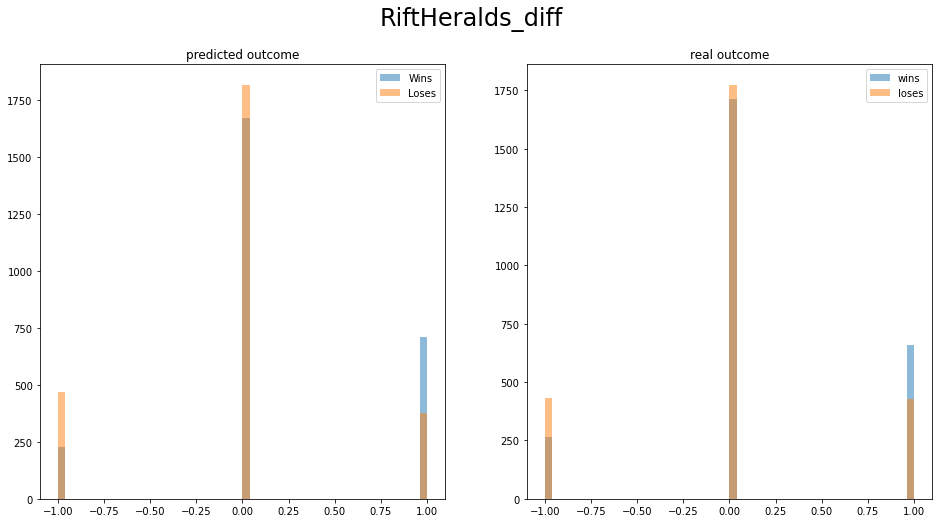

In [124]:
for col in blueWins.columns:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax[0].hist(blueWins[col], bins = 50, label = 'Wins', alpha = 0.5)
    ax[0].hist(blueLoses[col], bins = 50, label = 'Loses', alpha = 0.5)
    ax[1].hist(actualWins[col], bins = 50, label = 'wins', alpha = 0.5)
    ax[1].hist(actualLoses[col], bins = 50, label = 'loses', alpha = 0.5)
    ax[0].legend(loc = 'upper right')
    ax[1].legend(loc = 'upper right')
    ax[0].title.set_text("predicted outcome")
    ax[1].title.set_text("real outcome")
    fig.suptitle(col, fontsize=24)
    plt.show()

# Conclusion

We can clearly see that the more "difference" there is between,
the red and blue team the more accurate our prediction gets,
and that is a very good indicator, because well if the teams are "even",
at any point in the game it's reasonable to assume that they have about the
same chance of winning the game, and thus we can just "guess".

what we can see, is that any lead, expect "wards" has some sort
of effect on the likelyhood of the given team to win.
and "gold difference" being the best indicator.
( with makes sense as the team with most gold overally would
have higher levels, more drakes etc... ).

we can conclude from this data that, YES most games are indeed
If your team is behind at the 10-minutes mark it's very likely that your team will lose.

we can clearly see from the data, that our model predicts that at 5k gold difference
at 10 minutes there is no chance the team that is behind will comeback.

if we compare it to the actual data we can see that there is "sometimes"
a fluke, and the other team managed to come back but its about 2% of the time.


we can see some interesting insight our model predicts that first drake increases the
chance to win by a lot!, and losing the first drake otherwise.
while no first drake for any teams doesn't add any info ( as expected ).

on the other hand we see a similar story with rift-herald,
but it isn't as game changing as the first drake.

we can conclude that Trading drake for Herald is a GOOD decision,
and the drake should have higher priority over the rift herald.

so less interesting data, is the First inhibitor,
with is very rare that will happen in the 10 minutes mark,
but when its done, there is almost no chance the losing team would make
a comeback.


we can conclude that at least in "high elo" games,
with pro players we can predict at about 75% accuracy of the outcome of any game.


### thank you for reading.
#### this notebook was inspired by this one, <br> https://www.kaggle.com/kevinnolasco/predicting-wins-in-league-of-legends